# Generate dataset
This notebook demonstrates how to generate the semi-synthetic data for use with the deep spatial causal model.

In [1]:
# All we need to do is import the package we made to generate
# the data
import spatial_dataset

# import other requirements for this notebook
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Use the package, along with the given arguments to create
# an instance of the dataset
sd = spatial_dataset.SpatialDataset(
    "./durham/",
    25,
    12448,
    10
)

Temperature calculation

$$T_{synth, i} = \beta v_i + f(\tilde{v_i}) + \gamma X + U$$


$X$ refers to the percentage of each NLCD class contained within the designated window.

$\gamma$ refers to a set of coefficients that are multiplied by the 

In [4]:
sd.nlcd.mean(axis=(0,1))

array([0.00936766, 0.25682791, 0.17019873, 0.13388131, 0.03901344,
       0.00308042, 0.08996241, 0.11102492, 0.09380817, 0.00552536,
       0.01479259, 0.02808046, 0.00111338, 0.04135275, 0.0019705 ])

In [5]:
# This cell calculates all counterfactuals
nlcd = sd.nlcd.mean(axis=(0,1))

# NDVI 0, NDVI neighbor 0
Y_00 = sd.calc_temp(np.zeros((51,51)), nlcd, 0)

# NDVI 1, NDVI neighbor 0
ndvi = np.zeros((51,51))
ndvi[25,25] = 1
Y_10 = sd.calc_temp(ndvi, nlcd, 0)

# NDVI 1, NDVI neighbor 1
Y_11 = sd.calc_temp(np.ones((51,51)), nlcd, 0)

# NDVI 0, ndvi neighbor 1
ndvi = np.ones((51,51))
ndvi[25,25] = 0
Y_01 = sd.calc_temp(ndvi, nlcd, 0)

print(Y_00)
print(Y_01)
print(Y_10)
print(Y_11)

1.24028900621333
-2.2276304335406
-2.810166554633038
-6.2522920301637965


In [6]:
# Example output
names = ['x', 'y', 'nlcd', 'ndvi', 'temp', 'temp_01', 'temp_10', 'temp_00']

for n, v in zip(names, sd[0]):
    if v.shape != ():
        print(n, v.shape)
    else:
        print(n, 1)

x 1
y 1
nlcd (15,)
ndvi (51, 51)
temp 1
temp_01 1
temp_10 1
temp_00 1


# Let's look at what's actually in this dataset.

When you create the dataset, you get:
* coordinates
* The NLCD classes averaged over the window (so, an array of percentages, whose sum is 1)
* NDVI as a window, with dimensions (2W+1)x(2W+1), where W is the window size.
* A synthetically generated temperature value.

This synthetically generated temperature value is defined as:

$$T_{synth, i} = \beta v_i + f(\tilde{v_i}) + \gamma X + U$$

Where $v_i$ refers to the NDVI value at the center of the window, and $\tilde{v_i}$ is a spatially weighted average of the NDVI values surrounding that window. $\gamma$ is an array of randomly generated coefficients that are multiplied with $X$, the observed confound. Lastly $U$ is the unobserved confounder, which is randomly generated dataset.

Let's look at how each of these values can be visualized.

## First, let's look at simple coefficients

In [7]:
# print out direct effect coefficient, beta
print("Direct effect coefficient, beta: ", sd.de_coef)
print("Confound coefficients, gamma", sd.confound.coefs) 

Direct effect coefficient, beta:  -4
Confound coefficients, gamma [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258 0.02058449 0.96990985
 0.83244264 0.21233911 0.18182497]


## What does U look like?

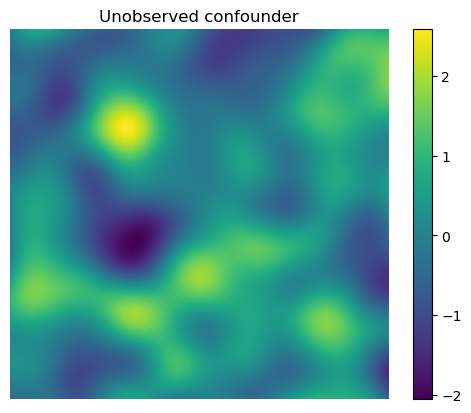

In [11]:
import matplotlib.pyplot as plt
plt.imshow(sd.U)
plt.axis('off')
plt.colorbar()
plt.title("Unobserved confounder")
plt.show()

In [12]:
print(sd.U.shape)

(2253, 2307)


So, we have an unobserved confounder that is the size of the entire dataset. We can look at the other variables, which match this dimension, too.

## Looking at NDVI

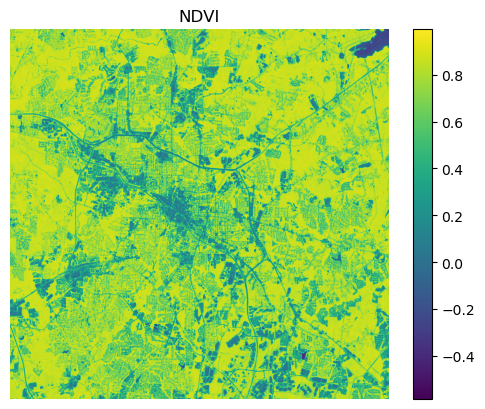

In [13]:
plt.imshow(sd.ndvi)
plt.axis('off')
plt.colorbar()
plt.title("NDVI")
plt.show()

## What does NLCD look like?

Well, let's just look at one of the indices.

In [14]:
print(sd.nlcd.shape)

(2253, 2307, 15)


So, there are 15 variables here, but overall, they are dominated by just a few classes, which you can see below:

In [15]:
import numpy as np
np.mean(sd.nlcd, axis=(0,1))

array([0.00936766, 0.25682791, 0.17019873, 0.13388131, 0.03901344,
       0.00308042, 0.08996241, 0.11102492, 0.09380817, 0.00552536,
       0.01479259, 0.02808046, 0.00111338, 0.04135275, 0.0019705 ])

The majority of the classes are indicies 1, 2, and 3. Let's just visualize index 1.

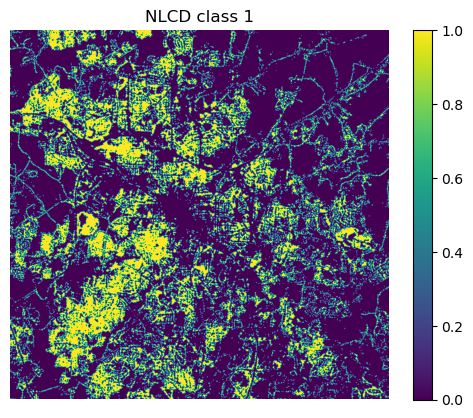

In [16]:
idx = 1
plt.imshow(sd.nlcd[:, :, idx])
plt.title("NLCD class " +str(idx))
plt.axis("off")
plt.colorbar()
plt.show()

Because this is a one-hot value at the pixel level, the values at each pixel are just going to be 0 or 1.

## Looking at the weight matrix.

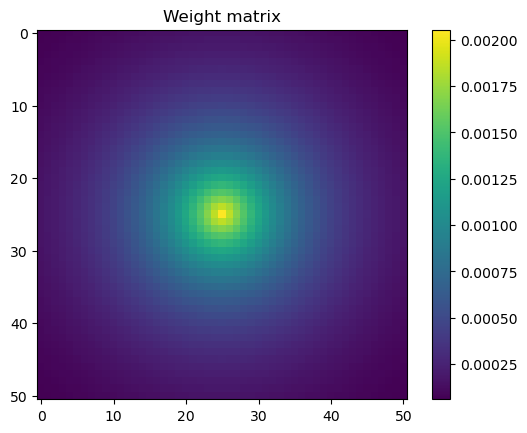

In [11]:
plt.imshow(sd.wm)
plt.colorbar()
plt.title("Weight matrix")
plt.show()

This weight matrix is what we multiply the NDVI with to get the spatially weighted version of the covariate.

## The random function
The spatially-weighted NDVI (or interfering treatment) is randomly generated -- let's look at what that function looks like.

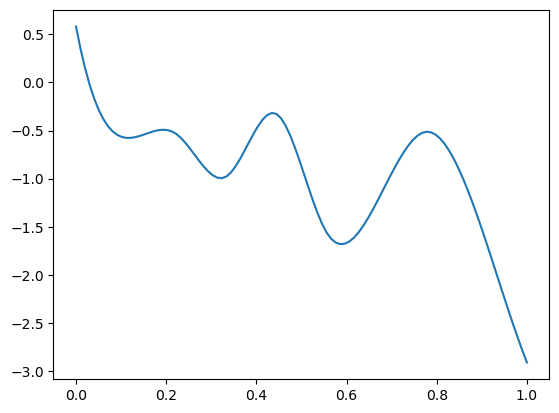

In [17]:
x = np.linspace(0, 1, 100)
y = sd.response(x)

plt.plot(x, y)

In [10]:
x = np.linspace(0, 1, 10)

y = np.random.multivariate_normal(1-3*x, 0.5*np.eye(10), 1)
# y = np.sort(y)
y = y.reshape(-1, 1)

# Now, we arblob:vscode-webview://1ef1mbmj3fe0tko2c05m83hk4q75uf0hdhelglsnnj462nujcjah/3b4462e0-5ceb-4474-a4b3-21edca62c990e going to create a cubic spline as the function
# This allows the random points to be converted to a smooth function
# cs = CubicSpline(x, y)

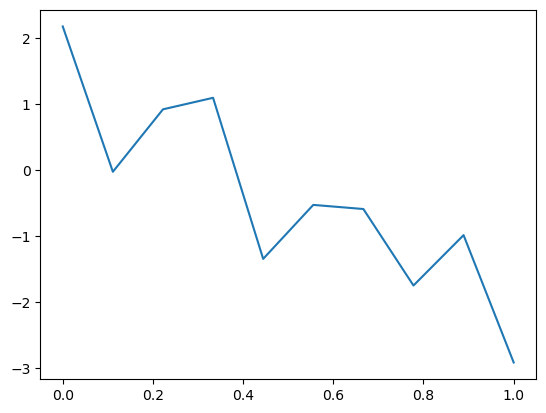

In [11]:
plt.plot(x, y)

So, the relationship is approximately linear, but not exactly so -- we could alter this function to look less linear if desired.

## Let's actually look at one tuple from this dataset

In [11]:
example = sd[0]

example

(1480,
 389,
 array([0.        , 0.        , 0.04152249, 0.43598616, 0.52249135,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([[-0.00387812, -0.00387812,  0.0314142 , ...,  0.35740072,
          0.28765061,  0.25213155],
        [ 0.03183024,  0.03183024, -0.01410331, ...,  0.22471042,
          0.22471042,  0.25079873],
        [ 0.03183024,  0.03183024, -0.01410331, ...,  0.25230512,
          0.25230512,  0.23909396],
        ...,
        [ 0.31877363,  0.45272923,  0.15320566, ...,  0.00483715,
          0.00183486,  0.01043219],
        [ 0.31629115,  0.49676025,  0.18668252, ...,  0.00483715,
          0.00183486,  0.01043219],
        [ 0.2679558 ,  0.4701087 ,  0.19935821, ...,  0.00278773,
          0.02115003,  0.00717482]], dtype=float32),
 2.477458664122614)

So, the first two values are coordinates, corresponding to the spatial index, the third value is the NLCD array the fourth value is the NDVI window, centered at the coordinates, and the last value is the predicted temperature (which is a random function, only observed at the coordinates generated).

These coordinates are randomly sampled when the dataset is initiailized (i.e., the num_samples argument).

In [12]:
print(len(sd.coords))

12448


We can see that there are 300 samples generated. Finally, if we actually wanted to use this dataset, we might just generate all of the temperature values, and save to a pickle, as the cell below is ready to do.

In [13]:
# To actually create the dataset for use, we are going to generate all of the data and save it.
data = []

for val in range(len(sd)):
    data.append(sd[val])

import pickle
# Save to a pickle file
with open("./pickles/semisynthetic_durham.pkl", "wb") as f:
    pickle.dump(data, f)

# Looking at a non-linear confound example

This dataset is set up so that we can look at a semi-synthetic dataset with a non-linear confounding effect, too.

In [1]:
# All we need to do is import the package we made to generate
# the data
import spatial_dataset

# import other requirements for this notebook
import numpy as np
import matplotlib.pyplot as plt

In [29]:
# Use the package, along with the given arguments to create
# an instance of the dataset
sd = spatial_dataset.SpatialDataset(
    "./durham/",
    25,
    12448,
    10,
    non_linear_confound = True,
    conf_layers = 3,
    conf_hidden = 10
)

19


This random confound function is a randomly initialized MLP that has the layers specified. The recommended settings for the number of layers and hidden layers appears to provide the desired amount of non-linearity in the response.

In [36]:
for row in sd.confound.coefs:
    print(row.shape)

(15, 10)
(10, 10)
(10, 10)
(10, 1)


Create semisynthetic dataset with the cell below:

In [31]:
# To actually create the dataset for use, we are going to generate all of the data and save it.
data = []

for val in range(len(sd)):
    data.append(sd[val])

# IF YOU WANT TO SAVE THE DATA, UNCOMMENT THIS CODE
# import pickle
# # Save to a pickle file# with open("./pickles/semisynthetic_durham.pkl", "wb") as f:
#     pickle.dump(data, f)

In [37]:
# Let's visualize this non-linear function
nlcd = []
t = []
for row in data:
    nlcd.append(row[2])
    t.append(sd.confound(row[2]))

nlcd = np.array(nlcd)

Example of nonlinear effect...as seen in first covariate:

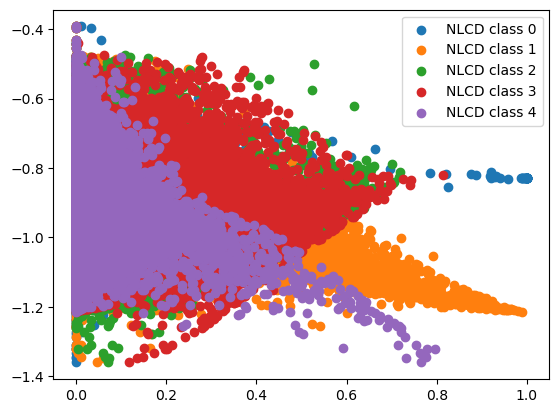

In [39]:
for i in [0, 1, 2, 3 , 4]:
    plt.scatter(nlcd[:, i], t, label = "NLCD class " + str(i))

plt.legend()

Let's visualize using PCA, too.

In [40]:
# Apply PCA to nlcd
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

pca.fit(nlcd)

nlcd_pca = pca.transform(nlcd)

# Plot the PCA
plt.scatter(nlcd_pca[:, 0], nlcd_pca[:, 1], c=t)
